## 05 - Görüntü Onarımı
### Bölüm 1 - Gürültü ve Gürültü Giderme

Bu defterde görüntülerdeki **gürültü** sorununu ve *görüntü restorasyon* yöntemleriyle görüntülerin **gürültüden arındırma** sürecini ele alıyoruz.

Görüntü restorasyonu, özellikle *bulanıklık* ve *gürültü* gibi görüntüyü bozan süreç hakkındaki ön bilgileri kullanarak görüntülerin görsel kalitesini iyileştirmekle ilgilidir. Görüntü kalitesinin iyileştirilmesine izin vermek için bir yöntemin keyfi olarak seçildiği görüntü iyileştirme tekniklerinin aksine, restorasyon genellikle görüntü oluşturma sürecini dikkate alır:

$$g(\mathbf{x}) = \mathcal{N} \left\lbrace f(\mathbf{x}) * h(\mathbf{x}) \right\rbrace,$$
burada $g$ gözlemlenen veya elde edilen görüntüdür, $f$ ideal veya orijinal görüntüdür, $h$ belirli bir pikselden gelen verilerin *yayılması* olarak tanımlanan görüntüde oluşan bozulmayı açıklayan filtredir $ f(\mathbf{x})$'ı $g(\mathbf{x})$ merkezli bir mahalleye bağlar ve $\mathcal{N}$, $g(\ görüntüsündeki *gürültüyü* açıklayan stokastik bir süreçtir. mathbf{x})$.

**Görüntü restorasyonu**, orijinal görüntü $f$'nin $\hat{f}$ tahminini elde etme işlemidir.

**Görüntü gürültüsünü giderme** gürültü sürecini tersine çevirmeyle ilgilenir. Matematiksel olarak daha izlenebilir hale getirmek için, genellikle dikkate alınan görüntü oluşturma süreci, ilave gürültüyü varsayan bir süreçtir:

$$g(\mathbf{x}) = [f(\mathbf{x}) * h(\mathbf{x})] + n(\mathbf{x}),$$
burada $n$ görüntüye gürültünün nasıl eklendiğini açıklayan bir fonksiyondur

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

### Gürültü dağılımları ve yapay gürültü üretimi

Genellikle bazı parametrik olasılık dağılımlarıyla modellenen birkaç gürültü dağılımını inceleyelim, örneğin:
* Tek tip: görüntüye eklenebilecek tüm değer aralıkları eşit derecede olasıdır
* Gaussian (normal): görüntüye eklenecek değerler, bir miktar ortalama (genellikle sıfır) ve standart sapma ile normal bir dağılım izler; böylece ortalamadan uzak değerlerin her iki taraftan da daha az olası olması sağlanır (pozitif ve negatif)

Toplama yoluyla verilen gürültüye ek olarak doğrusal olmayan gürültü süreçleri de vardır, örneğin
* Etkisel: Belirli bir pikseldeki hatayı temsil eder ve onu belirli değerlere dönüştürür. En yaygın olarak gözlemlenen değerler 0 (biber gürültüsü olarak da bilinir), 255 (tuz gürültüsü olarak da bilinir) veya her ikisidir (tuz ve biber). Dolayısıyla bu yalnızca sınırlı sayıda olası değeri dikkate alır, dolayısıyla 'dürtüsel'dir

Düzgün gürültüyle başlayalım

In [2]:
def uniform_noise(size, prob=0.1):
    '''
    Bir görüntüye eklenecek [0-255] aralığında düzgün gürültüye sahip bir matris oluşturur

    :param size: gürültü matrisinin boyutunu tanımlayan demet
    :param prob: düzgün gürültü üretimi olasılığı
    :prob yazın: kayan nokta
    :görüntüye eklenecek düzgün gürültüye sahip dönüş matrisi
    '''

    levels = int((prob * 255) // 2)
    noise = np.random.randint(-levels, levels, size)

    return noise

In [3]:
img = imageio.imread("/content/pattern2.png")
np.unique(img)

<ipython-input-3-04c48d1b8ca0>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("/content/pattern2.png")


array([ 32, 127, 186], dtype=uint8)

In [4]:
uni_noise = uniform_noise(img.shape, prob=0.1)
img_uni = np.clip(img.astype(int)+uni_noise, 0, 255)

hist_img,_ = np.histogram(img, bins=256, range=(0,255))
hist_uni,_ = np.histogram(img_uni, bins=256, range=(0,255))

<BarContainer object of 256 artists>

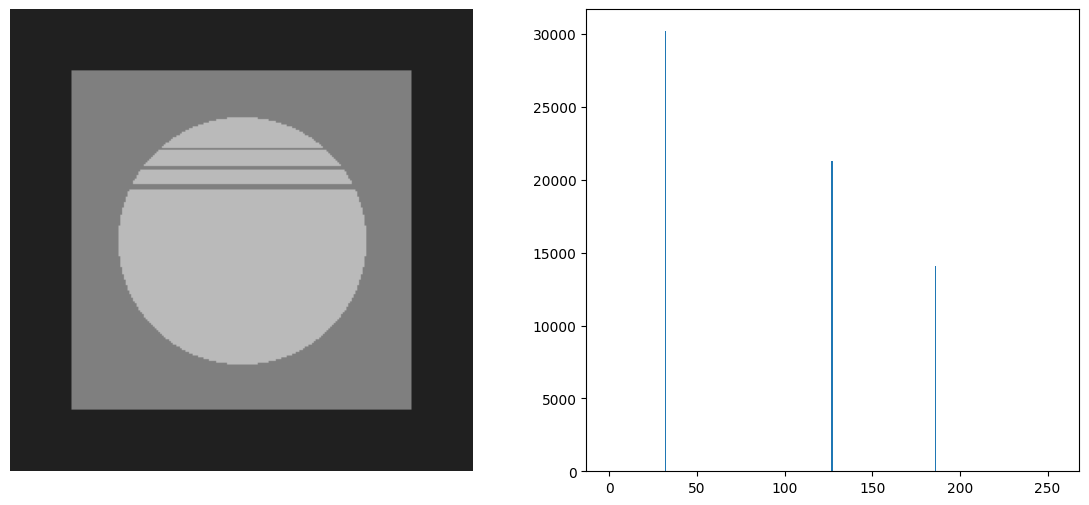

In [5]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.bar(np.arange(256), hist_img)

<BarContainer object of 256 artists>

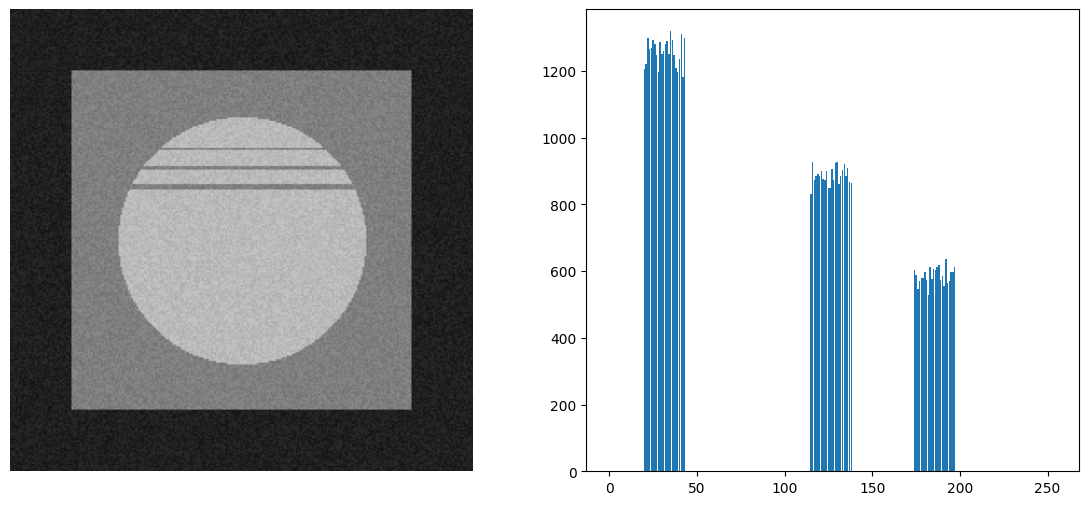

In [6]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(img_uni, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.bar(np.arange(256), hist_uni)

#print(np.unique(img_uni))

Gürültüsüz olan orijinal görüntünün yalnızca üç yoğunluk değerine (32, 127 ve 186) sahip olduğuna dikkat edin. Tek biçimli gürültü eklediğimizde, bu yoğunluklara değerler eklenir (veya çıkarılır), orijinal değerlerin etrafında daha geniş bir yoğunluk aralığı üretilir. Değerlerin yaklaşık olarak aynı olduğuna dikkat edin

In [7]:
def gaussian_noise(size, mean=0, std=0.01):
    '''
    Bir görüntüye eklenecek [0-255] aralığında Gauss gürültüsüne sahip bir matris oluşturur

    :param size: gürültü matrisinin boyutunu tanımlayan demet
    :param ortalama: Gauss dağılımının ortalaması
    :param std: Gauss dağılımının standart sapması, varsayılan 0,01
    :Görüntüye eklenecek Gauss gürültüsü içeren dönüş matrisi
    '''
    noise = np.multiply(np.random.normal(mean, std, size), 255)

    return noise

In [8]:
# eklenecek gürültü matrisinin oluşturulması
gau_noise = gaussian_noise(img.shape, mean=0, std=0.05)

# 0'ın altındaki veya 255'in üzerindeki değerleri ekleme ve kırpma
img_gau = np.clip(img.astype(int)+gau_noise, 0, 255)

hist_gau,_ = np.histogram(img_gau, bins=256, range=(0,255))

<BarContainer object of 256 artists>

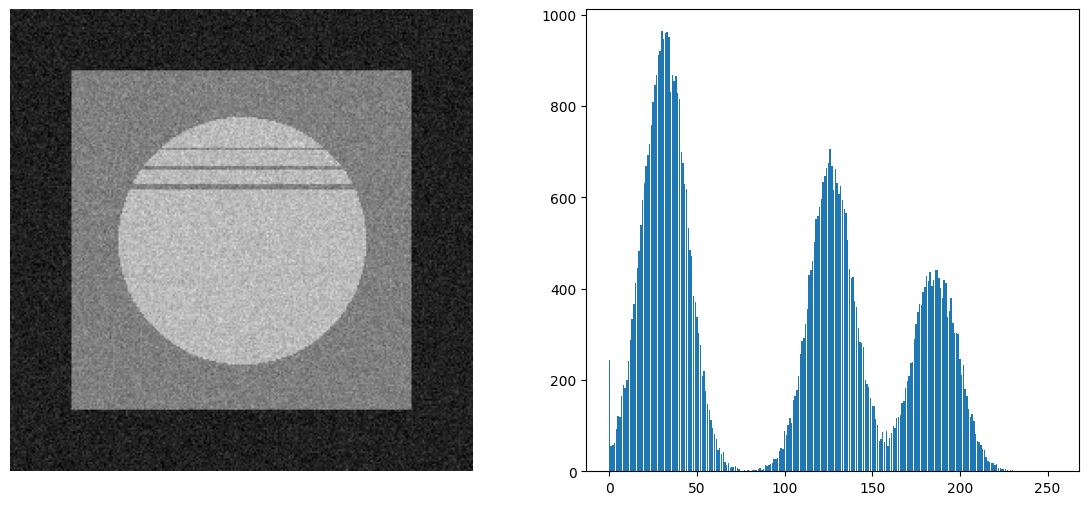

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(img_gau, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.bar(np.arange(256), hist_gau)

Gauss gürültüsü durumunda, değerlerin dağılımın ortalaması olan yoğunluk değerleri civarında olması daha olasıdır. Multimodal normal dağılımı gösteren histogram şekline dikkat edin.

In [10]:
def impulsive_noise(image, prob=0.1, mode='salt_and_pepper'):
    '''
    Belirli bir olasılıkla görüntüdeki pikselleri değiştirmek için görüntüyü dürtüsel gürültüyle (0 ve/veya 255) döndürür

    :param görüntüsü: giriş görüntüsü
    :param prob: dürtüsel gürültü üretimi olasılığı
    :param modu: gürültü türü, 'tuz', 'biber' veya 'tuz_ve_biber' (varsayılan)
    :prob yazın: kayan nokta
    : Ani gürültü içeren gürültülü görüntüyü döndürür
    '''

    noise = np.array(image, copy=True)
    for x in np.arange(image.shape[0]):
        for y in np.arange(image.shape[1]):
            rnd = np.random.random()
            if rnd < prob:
                rnd = np.random.random()
                if rnd > 0.5:
                    noise[x,y] = 255
                else:
                    noise[x,y] = 0

    return noise

In [11]:
img_imp = impulsive_noise(img, prob=0.1)

hist_imp,_ = np.histogram(img_imp, bins=256, range=(0,255))

<BarContainer object of 256 artists>

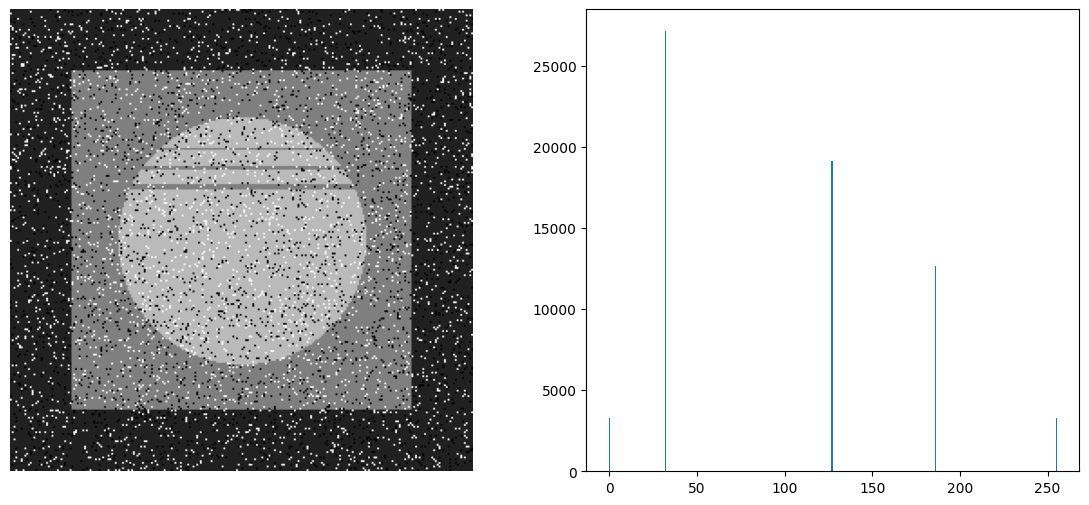

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(img_imp, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.bar(np.arange(256), hist_imp)

### Gürültü giderme yöntemleri

Prensip olarak, toplamsal bir gürültü oluşumu göz önüne alındığında, yalnızca gürültüyü üretebilir ve onu görüntüden çıkarabilirsiniz. Ancak bu istenilen sonuçları vermeyebilir. Bu nedenle, *Gaussian* filtresi, *Medyan* filtresi gibi yumuşatma filtreleri, görüntülerin gürültüsünü gidermek amacıyla varyansı yerel olarak azaltmak için kullanılabilir.

In [13]:
# gürültü oluşturmak ve onu görüntüden çıkarmak
uni_noise_new = uniform_noise(img.shape, prob=0.1)
img_uni_res = img_uni - uni_noise_new

def rmse(f,g):
    size = f.shape
    return np.sqrt(np.sum(np.square(f-g))/(size[0]*size[1]))

print("Error between noisy and original: %.3f%%" % (rmse(img.astype(float), img_uni.astype(float))))
print("Error between 'restored' and original: %.3f%%" % (rmse(img_uni_res.astype(float), img.astype(float))))

Error between noisy and original: 6.925%
Error between 'restored' and original: 9.792%


Hata azalmak yerine arttı ve görüntüleri görselleştirmenin gerçekten de görüntüye daha fazla gürültü kattığını onaylıyoruz.

(-0.5, 255.5, 255.5, -0.5)

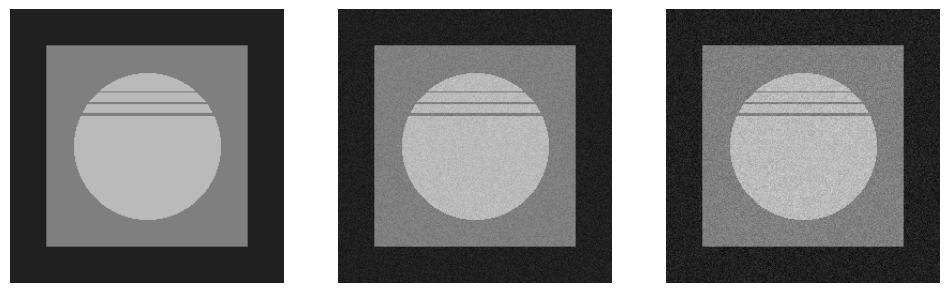

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(img_uni, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(img_uni_res, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Gürültü giderme filtreleri

Gürültüyü azaltmak için filtre oluşturalım. Pek çok seçenek vardır; en yaygın kullanılanlar ortalama, Gaussian ve medyandır. Yöntemin seçimi gürültüye bağlıdır

Tüm gürültü giderici filtreler yerel varyansı azaltarak çalışır.

In [15]:
# fft algoritmalarını içe aktarma
# dönüşüm, ters çevirme ve kaydırma yöntemleri dahil
from scipy.fftpack import fftn, ifftn, fftshift

In [16]:
# yeni bir görüntüyü okuma ve Gauss gürültüsünü dahil etme
f = imageio.imread("/content/moon2.jpg")
g = f + gaussian_noise(f.shape, mean=0, std=0.08)
g = np.clip(g.astype(int), 0, 255)

# 7x7 ortalama filtresi oluşturma
K = 7
w_mean = np.ones([K,K])/float(K*K)

def fft_imagefilter(g, w):
    '''
     Bir görüntüyü g filtresiyle filtrelemek için bir işlev w
    '''
    # filtreyi görüntüyle aynı boyuta sahip olacak şekilde doldurma
    pad1 = (g.shape[0]//2)-w.shape[0]//2
    wp = np.pad(w, (pad1,pad1-1), "constant",  constant_values=0)

    # Fourier dönüşümlerini hesaplamak
    W = fftn(wp)
    G = fftn(g)
    R = np.multiply(W,G)

    r = np.real(fftshift(ifftn(R)))
    return r

r_mean = fft_imagefilter(g, w_mean)

<ipython-input-16-6036ea152589>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f = imageio.imread("/content/moon2.jpg")


(-0.5, 255.5, 255.5, -0.5)

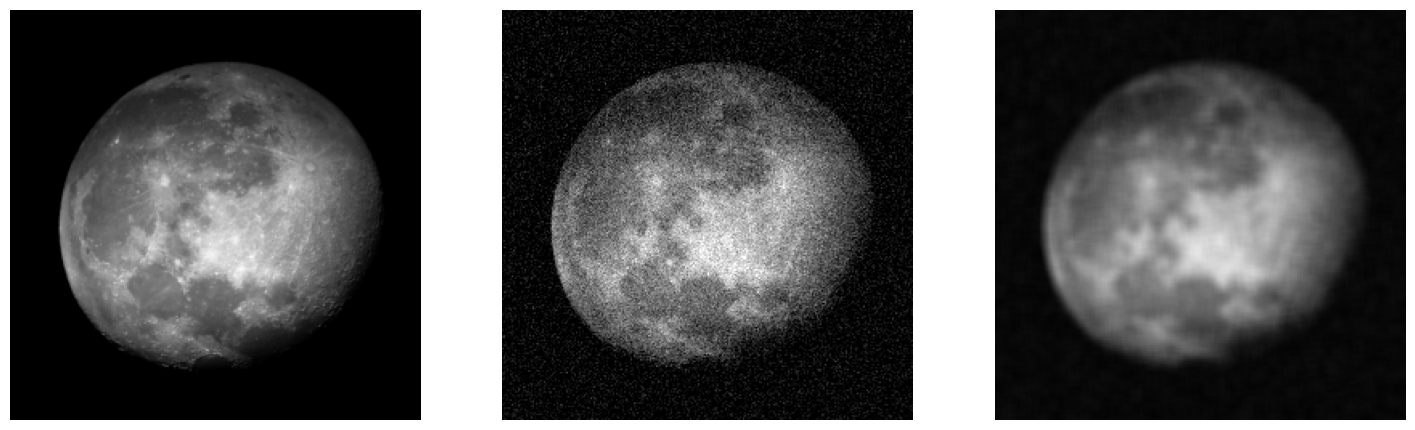

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.axis('off')
plt.subplot(132)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.axis('off')
plt.subplot(133)
plt.imshow(r_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off')

Bir filtre doğrusal olduğunda FFT'lerle hesaplama yapabiliriz ancak medyan gibi sıra istatistik filtreleri için optimizasyon yapmak daha zordur. Burada bunu piksel piksel yapıyoruz.

In [18]:
def medianfilter(g, k):
    '''
     K boyutunda bir medyan filtresi
    '''
    a = k//2
    r = np.zeros(g.shape)
    for x in np.arange(a, g.shape[0]-a+1):
        for y in np.arange(a, g.shape[1]-a+1):
            med_region = np.median(g[x-a:x+a+1, y-a:y+a+1])
            r[x,y] = med_region

    return r

r_median = medianfilter(g,7)

Text(0.5, 1.0, 'median filter')

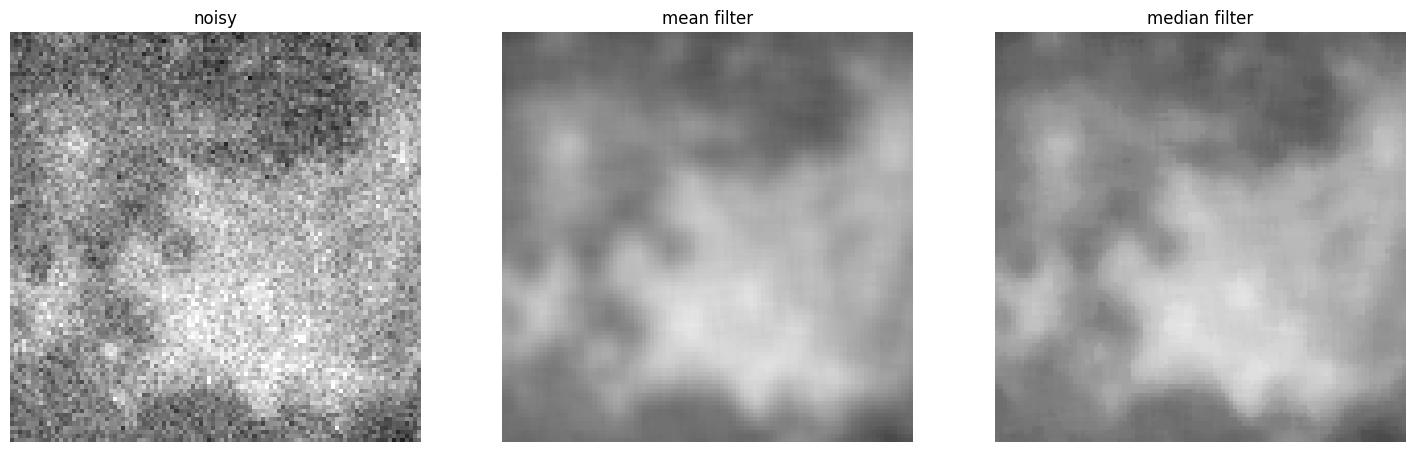

In [19]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(g[80:180,80:180], cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(132)
plt.imshow(r_mean[80:180,80:180], cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('mean filter')
plt.subplot(133)
plt.imshow(r_median[80:180,80:180], cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('median filter')

In [20]:
print("Error between mean-filtered and original: %.3f%%" % (rmse(f.astype(float), r_mean.astype(float))))
print("Error between median-filtered and original: %.3f%%" % (rmse(f.astype(float), r_median.astype(float))))

Error between mean-filtered and original: 8.936%
Error between median-filtered and original: 6.517%


Biz de aynısını yapalım ama tuz ve biber gürültüsü içeren bir görüntü için. $3\times 3$ boyutunda bir ortalama filtre ile bir medyan filtrenin karşılaştırılması

In [21]:
img_imp = impulsive_noise(img, prob=0.05)

w_mean3 = np.ones([3,3])/float(3*3)
img_mean = fft_imagefilter(img_imp, w_mean3)
img_median = medianfilter(img_imp, 3)

Text(0.5, 1.0, 'median filter')

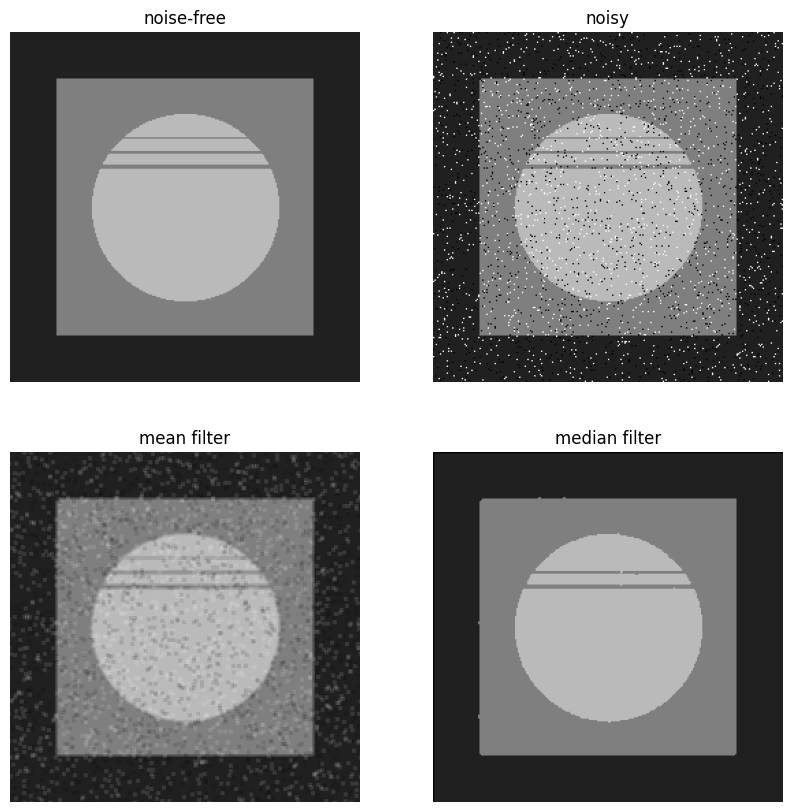

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noise-free')
plt.subplot(222)
plt.imshow(img_imp, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(223)
plt.imshow(img_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('mean filter')
plt.subplot(224)
plt.imshow(img_median, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('median filter')

Bu, onu ortadan kaldıracak bir filtre tasarlamadan önce gürültü sürecini bilmenin ne kadar anlamlı olduğunu gösterir.